<a href="https://colab.research.google.com/github/canamac/zeka-can/blob/main/trendsense1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Cloning https://github.com/rongardF/tvdatafeed to /tmp/pip-req-build-lu_p33o1
  Running command git clone --filter=blob:none --quiet https://github.com/rongardF/tvdatafeed /tmp/pip-req-build-lu_p33o1
  Resolved https://github.com/rongardF/tvdatafeed to commit e6f6aaa7de439ac6e454d9b26d2760ded8dc4923
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 531.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 43.7 MB/s eta 0:00:00
  Created wheel for tvdatafeed: filename=tvdatafeed-2.1.0-py3-none-any.whl size=17533 sha256=a56fecc6546af3f1cf9076476ee25319da4ff6719fe7c3b34677cd2c97330d0c
  Stored in directory: /tmp/pip-ephem-wheel-cache-opov5lgn/wheels/e4/32/1e/21ebcacc6549d75fae3bf3ff75cee8fcbe4e5c189d88fbd5a1
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=1739

['ARCLK', 173.6, 'True']
['ATATP', 141.0, 'True']
['BRSAN', 499.5, 'True']
['BSOKE', 29.0, 'True']
['EGEPO', 20.48, 'True']


ERROR:tvDatafeed.main:Connection to remote host was lost.
ERROR:tvDatafeed.main:no data, please check the exchange and symbol


Error processing EKIZ: 'NoneType' object has no attribute 'rename'
['GLYHO', 15.64, 'True']
['GZNMI', 33.92, 'True']
['ICUGS', 13.35, 'True']
['KAYSE', 28.5, 'True']
['KLSER', 48.72, 'True']
['KRDMD', 30.88, 'True']
['KUYAS', 48.0, 'True']
['MGROS', 533.0, 'True']
['MPATA', 3128.0, 'True']
['OYLUM', 10.18, 'True']
['PASEU', 71.0, 'True']
['QPERP', 5067.0, 'True']
['RODRG', 137.9, 'True']
['SURGY', 48.4, 'True']
['VAKFN', 3.41, 'True']
['ZOREN', 5.62, 'True']
+----+-------------+-------------+-----------------+
|    | Hisse Adı   |   Son Fiyat | Giriş Sinyali   |
+====+=============+=============+=================+
|  0 | ARCLK       |      173.6  | True            |
+----+-------------+-------------+-----------------+
|  1 | ATATP       |      141    | True            |
+----+-------------+-------------+-----------------+
|  2 | BRSAN       |      499.5  | True            |
+----+-------------+-------------+-----------------+
|  3 | BSOKE       |       29    | True            |
+----+-

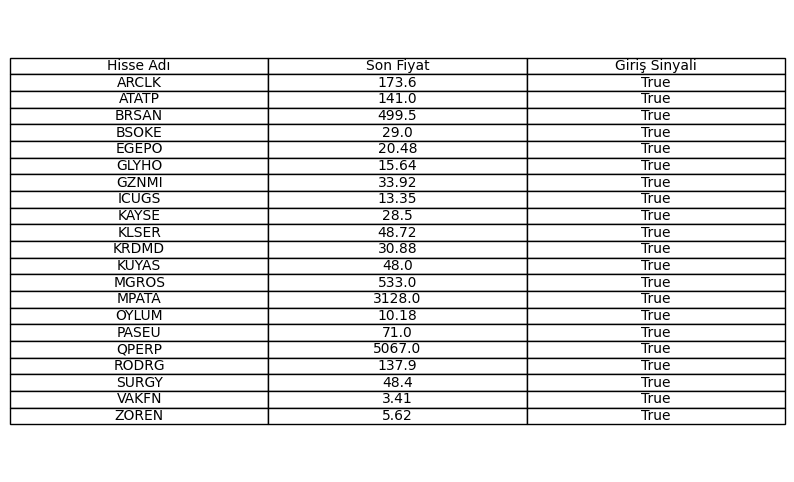

In [ ]:
!pip install git+https://github.com/rongardF/tvdatafeed tradingview-screener backtesting
import pandas as pd
import numpy as np
from tvDatafeed import TvDatafeed, Interval
from tradingview_screener import get_all_symbols
import warnings
import matplotlib.pyplot as plt
from tabulate import tabulate

warnings.simplefilter(action='ignore', category=FutureWarning)

def ema(series, length):
    return series.ewm(span=length, adjust=False).mean()

def rsi(series, length):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=length).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=length).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def NQQE(data, length=14, SSF=5):
    df = data.copy()
    df['RSI'] = rsi(df['Close'], length)
    df['RSII'] = ema(df['RSI'], SSF)
    df['TR'] = (df['RSII'] - df['RSII'].shift(1)).abs()
    df['wwalpha'] = 1 / length
    df['WWMA'] = df['wwalpha'] * df['TR'] + (1 - df['wwalpha']) * df['TR'].shift(1)
    df['ATRRSI'] = df['wwalpha'] * df['WWMA'] + (1 - df['wwalpha']) * df['WWMA'].shift(1)
    df['QQEF'] = ema(df['RSI'], SSF)
    df['QUP'] = df['QQEF'] + df['ATRRSI'] * 4.236
    df['QDN'] = df['QQEF'] - df['ATRRSI'] * 4.236
    df['QQES'] = 0.0

    for i in range(1, len(df)):
        if df['QUP'][i] < df['QQES'][i-1]:
            df.at[i, 'QQES'] = df['QUP'][i]
        elif df['QQEF'][i] > df['QQES'][i-1] and df['QQEF'][i-1] < df['QQES'][i-1]:
            df.at[i, 'QQES'] = df['QDN'][i]
        elif df['QDN'][i] > df['QQES'][i-1]:
            df.at[i, 'QQES'] = df['QDN'][i]
        elif df['QQEF'][i] < df['QQES'][i-1] and df['QQEF'][i-1] > df['QQES'][i-1]:
            df.at[i, 'QQES'] = df['QUP'][i]
        else:
            df.at[i, 'QQES'] = df['QQES'][i-1]

    df['Colorh'] = np.where(df['QQEF'] - 50 > 10, '#007002', np.where(df['QQEF'] - 50 < -10, 'red', '#E8E81A'))
    df['QQF'] = df['QQEF'] - 50
    df['QQS'] = df['QQES'] - 50
    df['buySignalr'] = (df['QQEF'] > df['QQES'])
    df['sellSignallr'] = (df['QQEF'] < df['QQES'])
    df['Entry'] = df['buySignalr']
    df['Exit'] = df['sellSignallr']

    return df

tv = TvDatafeed()
Hisseler = get_all_symbols(market='turkey')
Hisseler = [symbol.replace('BIST:', '') for symbol in Hisseler]
Hisseler = sorted(Hisseler)

# Raporlama için kullanılacak başlıklar
Titles = ['Hisse Adı', 'Son Fiyat', 'Giriş Sinyali']

df_signals = pd.DataFrame(columns=Titles)

for i in range(0, len(Hisseler)):
    try:
        data = tv.get_hist(symbol=Hisseler[i], exchange='BIST', interval=Interval.in_1_hour, n_bars=500)
        data.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)
        data = data.reset_index()
        nqqeTrend = NQQE(data, 14, 5)
        nqqeTrend['datetime'] = pd.to_datetime(nqqeTrend['datetime'])  # Assuming 'datetime' is the name of your datetime column
        nqqeTrend.set_index('datetime', inplace=True)
        Buy = False
        Signals = nqqeTrend.tail(2)
        Signals = Signals.reset_index()
        Buy = Signals.loc[0, 'Entry'] == False and Signals.loc[1, 'Entry'] == True
        Last_Price = Signals.loc[1, 'Close']
        if Buy:
            L1 = [Hisseler[i], Last_Price, str(Buy)]
            df_signals.loc[len(df_signals)] = L1
            print(L1)
    except Exception as e:
        print(f"Error processing {Hisseler[i]}: {e}")

df_True = df_signals[df_signals['Giriş Sinyali'] == 'True']

print(tabulate(df_True, headers='keys', tablefmt='grid'))

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=df_True.values, colLabels=df_True.columns, cellLoc='center', loc='center')
plt.show()